In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/MyDrive/Colab Notebooks/AN2DL - Homework 2"
%ls

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1wicGwA3-2pgoUsO_xlLNF-McRRaAK_QO/AN2DL - Homework 2
21-12-13_FirstNotebook/
21-12-15_FNNotebook+RMSE_loss+Dropout+1_LSTM/
21-12-15_FNotebook+RMSE_Loss/
21-12-15_FNotebook+RMSE_Loss+Dropout/
21-12-16_FNotebook+ParamsTuning-1/
21-12-16_FNotebook+Params_Tuning-3-ERROR/
21-12-16_FNotebook+Params_Tuning-3_LAYERS_CORRECT/
21-12-16_SecondModel-BiLSTM+ParamsTuning/
21-12-16_SModel-BiLSTM+3Layer/
21-12-16_SModel-BiLSTM+ParamsTuning-2/
Accuracy.png
Check.ipynb
dataset.csv
LearningRate.png
model.png
RMSE_loss.png


Import Libraries

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


Set a global Seed

In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Load data

In [4]:
dataset = pd.read_csv('dataset.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


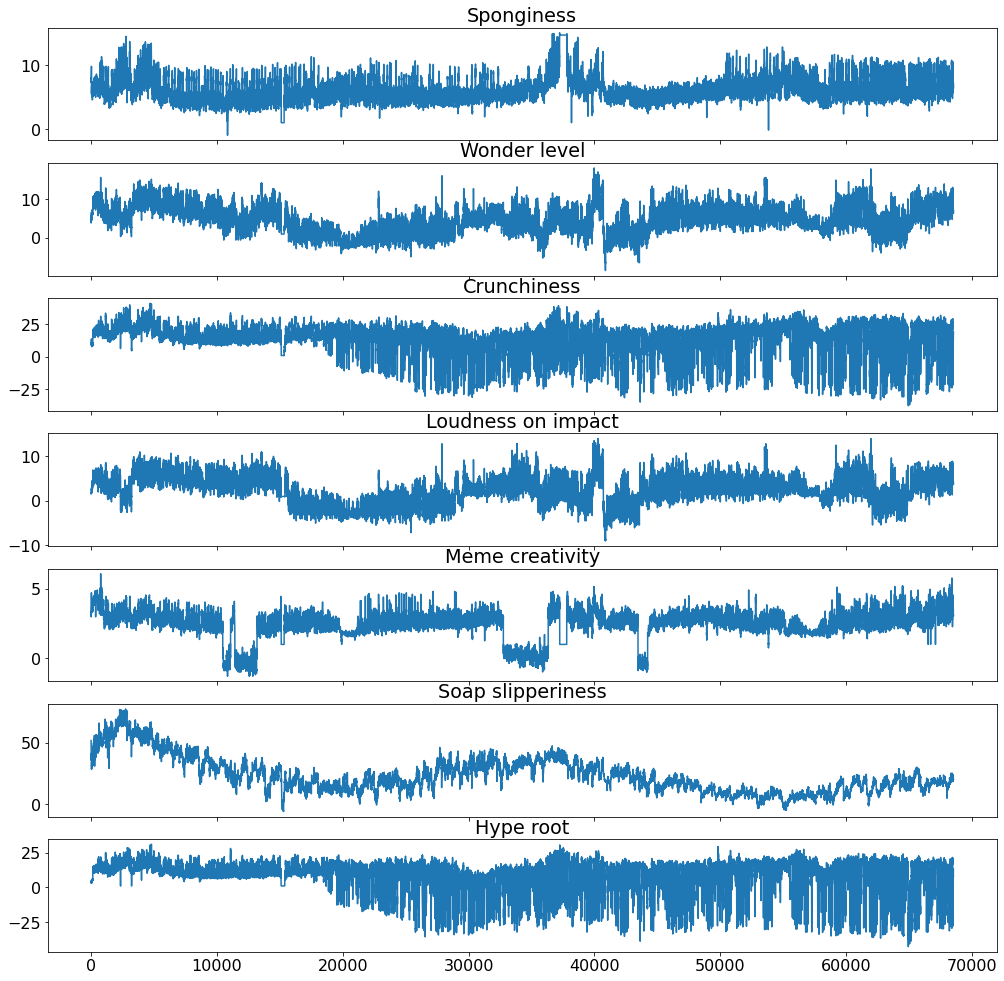

In [6]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Training data Normalization

In [7]:
X_train_raw = pd.DataFrame(dataset)
print(X_train_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)


(68528, 7)


In [8]:
window = 500
stride = 5
telescope = 864
targets_labels = dataset.columns

In [9]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 500, 7)

In [10]:
def build_sequences(df, target_labels=targets_labels, window=200, stride=10, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

Multivariate Forecasting (Direct)

In [11]:
X_train, y_train = build_sequences(X_train_raw, targets_labels, window, stride, telescope)
X_train.shape, y_train.shape

((13528, 500, 7), (13528, 864, 7))

In [12]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

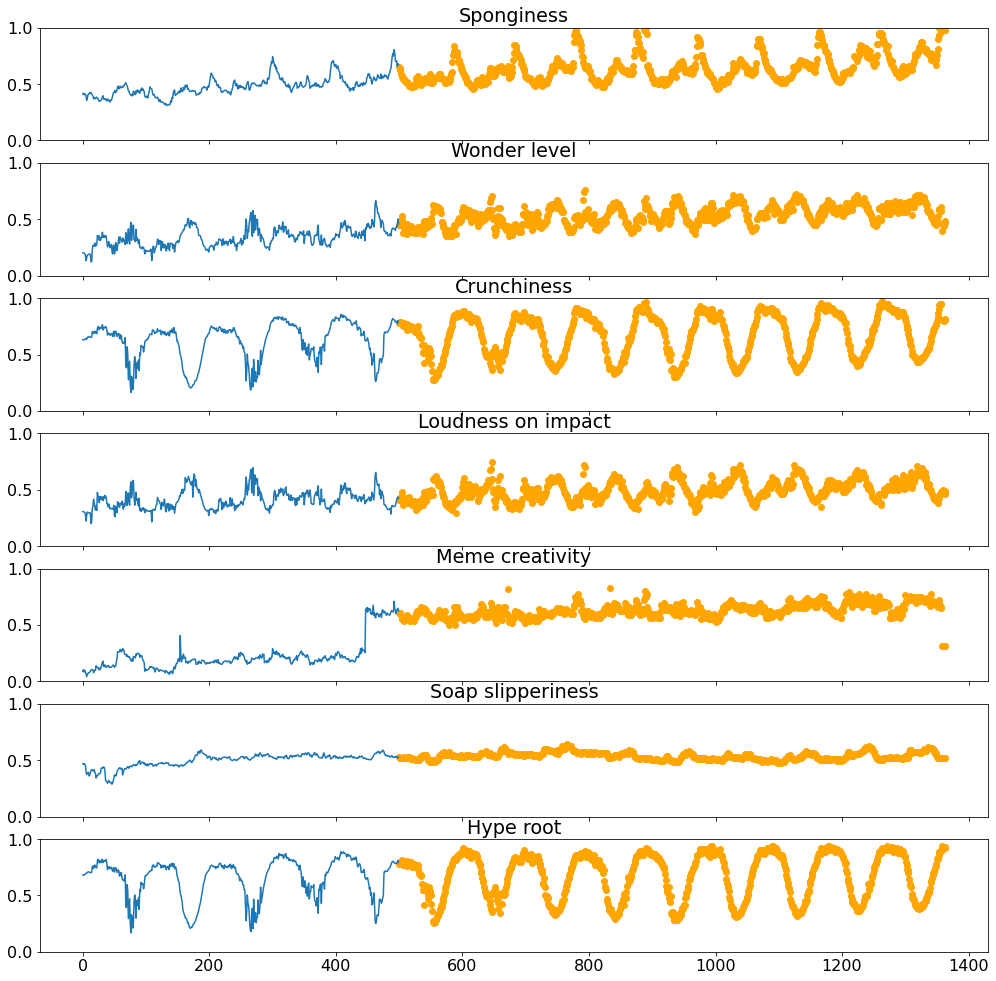

In [13]:
inspect_multivariate(X_train, y_train, targets_labels, telescope)

In [14]:
input_shape = X_train.shape[1:]
print(input_shape)
output_shape = y_train.shape[1:]
print(output_shape)
channels = X_train.shape[-1]
print(channels)
batch_size = 64
epochs = 200

(500, 7)
(864, 7)
7


In [15]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [16]:
def build(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.LSTM(32, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(64, return_sequences=True)(lstm)
    lstm = tfkl.LSTM(128)(lstm)

    dense = tfkl.Dense(channels*telescope, activation='relu')(lstm)
    output_layer = tfkl.Reshape((telescope,channels))(dense)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=root_mean_squared_error, optimizer=tfk.optimizers.Adam(), metrics=[tf.keras.metrics.RootMeanSquaredError(),"accuracy"])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 500, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 500, 32)           5120      
                                                                 
 lstm_1 (LSTM)               (None, 500, 64)           24832     
                                                                 
 lstm_2 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 6048)              780192    
                                                                 
 reshape (Reshape)           (None, 864, 7)            0         
                                                                 
Total params: 908,960
Trainable params: 908,960
Non-trainable

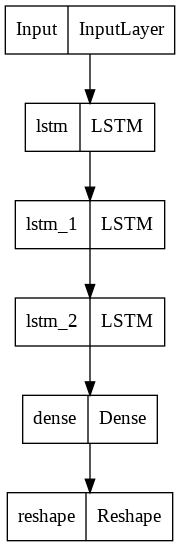

In [17]:
model = build(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [18]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
191/191 [==============================] - 55s 248ms/step - loss: 0.3327 - root_mean_squared_error: 0.3344 - accuracy: 0.5361 - val_loss: 0.3253 - val_root_mean_squared_error: 0.3256 - val_accuracy: 0.4898 - lr: 0.0010
Epoch 2/200
191/191 [==============================] - 45s 234ms/step - loss: 0.3119 - root_mean_squared_error: 0.3120 - accuracy: 0.5844 - val_loss: 0.3107 - val_root_mean_squared_error: 0.3110 - val_accuracy: 0.5115 - lr: 0.0010
Epoch 3/200
191/191 [==============================] - 45s 235ms/step - loss: 0.2869 - root_mean_squared_error: 0.2871 - accuracy: 0.6143 - val_loss: 0.2752 - val_root_mean_squared_error: 0.2753 - val_accuracy: 0.5422 - lr: 0.0010
Epoch 4/200
191/191 [==============================] - 45s 237ms/step - loss: 0.2588 - root_mean_squared_error: 0.2589 - accuracy: 0.6528 - val_loss: 0.2516 - val_root_mean_squared_error: 0.2518 - val_accuracy: 0.5598 - lr: 0.0010
Epoch 5/200
191/191 [==============================] - 46s 240ms/step - loss

/gdrive/.shortcut-targets-by-id/1wicGwA3-2pgoUsO_xlLNF-McRRaAK_QO/AN2DL - Homework 2/21-12-16_FNotebook+Params_Tuning-3_LAYERS_CORRECT


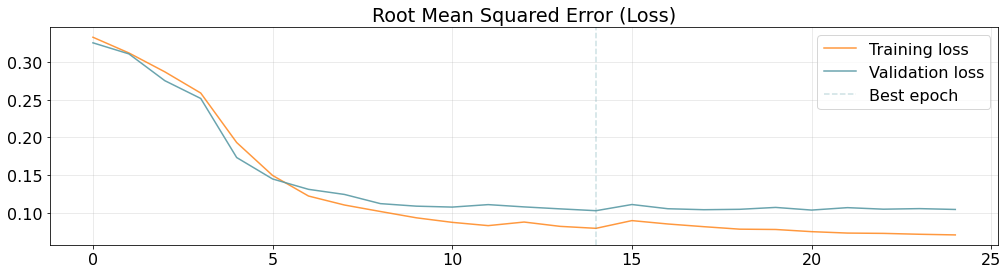

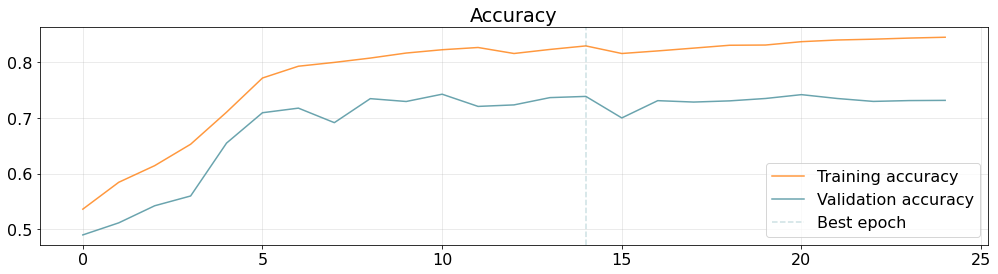

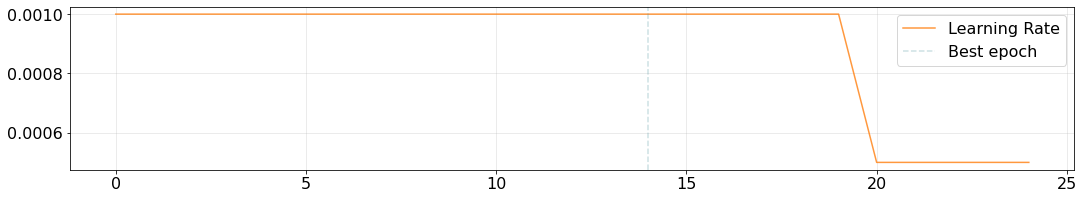

In [19]:
%cd 21-12-16_FNotebook+Params_Tuning-3_LAYERS_CORRECT/
best_epoch = np.argmin(history['val_loss'])
fig = plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Root Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()
fig.savefig('RMSE_loss')

fig = plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()
fig.savefig('Accuracy.png')

fig = plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()
fig.savefig('LearningRate')

In [20]:
model.save('FNotebook+ParamsTuning-3_Layers')